In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision
import numpy as np
import wandb
from datetime import date
import pandas as pd
import os

from conv_net import *
from conv_traintest import *
from utils import *
from FTTP import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
torch.manual_seed(999)

cuda


In [2]:
###############################################################
# IMPORT DATASET
###############################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 200

traindata = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)

testdata = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

# data loading
train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                           shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# check data loading correctness
for batch_idx, (data, target) in enumerate(train_loader):
    sample_data = data
    print(data.shape)
    _, c, h, w = data.shape
    break

torch.Size([200, 1, 28, 28])


In [3]:
# training parameters
T = 20
n_classes = 10

###############################################################
# DEFINE NETWORK
###############################################################

# set input and t param

IN_dim = [c, h, w]
hidden_channels = [8, 8, 8]
kernel_size = [3, 3, 3]
stride = [1, 1, 1]
paddings = [0, 0, 0]
pooling = None
num_readout = 10
conv_adp = True
syn_curr_conv = False
is_rec = [False, False, False]
dp=0.2


# define network
model = SnnConvNet3Layer(IN_dim, hidden_channels, kernel_size, stride,
                   paddings, n_classes, is_adapt_conv=conv_adp,
                   syn_curr_conv=syn_curr_conv, dp_rate=dp, p_size=num_readout, 
                   pooling=pooling, is_rec=is_rec)
model.to(device)
print(model)

SNN-conv + None
output size 5408
SNN-conv + None
output size 4608
SNN-conv + None
output size 3872


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


SnnConvNet3Layer(
  (dp): Dropout2d(p=0.2, inplace=False)
  (h_layer): SnnLayer(
    (fc_weights): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (conv1): SNNConvCell(
    (conv_in): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): SNNConvCell(
    (conv_in): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_to_pop): Linear(in_features=3872, out_features=100, bias=True)
  (pop_enc): SnnLayer(
    (rec_w): Linear(in_features=100, out_features=100, bias=True)
    (sigmoid): Sigmoid()
  )
  (pop_to_conv): Linear(in_features=100, out_features=3872, bias=True)
  (deconv2): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (deconv1): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
  (output

In [4]:
exp_dir_bp = '/home/lucy/spikingPC/results/Mar-01-2023/conv_fptt_ener1_rec_conv_3l_outtaufixed/'
saved_dict_bp = model_result_dict_load(exp_dir_bp + 'onelayer_rec_best.pth.tar')

model.load_state_dict(saved_dict_bp['state_dict'])
model.eval()

SnnConvNet3Layer(
  (dp): Dropout2d(p=0.2, inplace=False)
  (h_layer): SnnLayer(
    (fc_weights): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (conv1): SNNConvCell(
    (conv_in): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): SNNConvCell(
    (conv_in): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_to_pop): Linear(in_features=3872, out_features=100, bias=True)
  (pop_enc): SnnLayer(
    (rec_w): Linear(in_features=100, out_features=100, bias=True)
    (sigmoid): Sigmoid()
  )
  (pop_to_conv): Linear(in_features=100, out_features=3872, bias=True)
  (deconv2): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (deconv1): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
  (output

In [6]:
param_names = []
param_dict = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        param_names.append(name)
        param_dict[name] = param.detach().cpu().numpy()

print(param_names)

['h_layer.tau_adp', 'h_layer.tau_m', 'h_layer.tau_i', 'h_layer.fc_weights.weight', 'h_layer.fc_weights.bias', 'conv1.tau_m', 'conv1.tau_adp', 'conv1.tau_i', 'conv1.conv_in.weight', 'conv1.conv_in.bias', 'conv1.BN.weight', 'conv1.BN.bias', 'conv2.tau_m', 'conv2.tau_adp', 'conv2.tau_i', 'conv2.conv_in.weight', 'conv2.conv_in.bias', 'conv2.BN.weight', 'conv2.BN.bias', 'conv_to_pop.weight', 'conv_to_pop.bias', 'pop_enc.tau_adp', 'pop_enc.tau_m', 'pop_enc.tau_i', 'pop_enc.rec_w.weight', 'pop_enc.rec_w.bias', 'pop_to_conv.weight', 'pop_to_conv.bias', 'deconv2.weight', 'deconv2.bias', 'deconv1.weight', 'deconv1.bias', 'conv3.tau_m', 'conv3.tau_adp', 'conv3.tau_i', 'conv3.conv_in.weight', 'conv3.conv_in.bias', 'conv3.BN.weight', 'conv3.BN.bias', 'deconv3.weight', 'deconv3.bias']


In [7]:
weights = [x for x in param_names if ('weight' in x) and ('BN' not in x)][2:] # exclude h layer weights
weights

['conv1.conv_in.weight',
 'conv2.conv_in.weight',
 'conv_to_pop.weight',
 'pop_enc.rec_w.weight',
 'pop_to_conv.weight',
 'deconv2.weight',
 'deconv1.weight',
 'conv3.conv_in.weight',
 'deconv3.weight']

In [10]:
connection_type = ['ff', 'ff', 'ff', 'rec', 'fb', 'fb', 'fb', 'ff', 'fb']

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'conv1.conv_in.weight'),
  Text(1, 0, 'conv2.conv_in.weight'),
  Text(2, 0, 'conv_to_pop.weight'),
  Text(3, 0, 'pop_enc.rec_w.weight'),
  Text(4, 0, 'pop_to_conv.weight'),
  Text(5, 0, 'deconv2.weight'),
  Text(6, 0, 'deconv1.weight'),
  Text(7, 0, 'conv3.conv_in.weight'),
  Text(8, 0, 'deconv3.weight')])

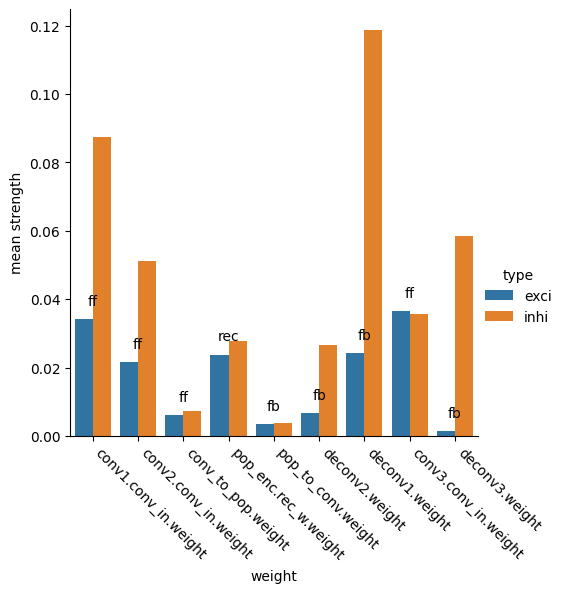

In [11]:
exci = []
inhi = []

for name in weights:
    w = param_dict[name]
    exci.append(((w>0)*w).mean())
    inhi.append(-((w<0)*w).mean())

df = pd.DataFrame({
    'weight': weights * 2,
    'connection type': connection_type * 2,
    'mean strength': exci + inhi,
    'type': ['exci'] * len(exci) + ['inhi'] * len(inhi)
})

sns.catplot(
    data=df, x="weight", y="mean strength", hue='type',
    kind="bar"
)

for i, label in enumerate(weights):
    plt.annotate(connection_type[i], (i, df['mean strength'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xticks(rotation=-45, ha='left')


<AxesSubplot: >

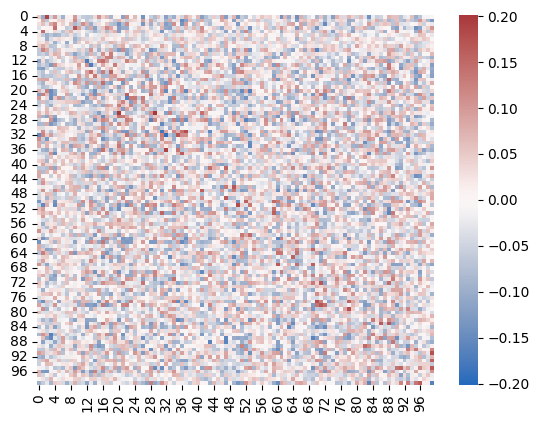

In [12]:
max = np.max(np.abs(param_dict['pop_enc.rec_w.weight']))
sns.heatmap(param_dict['pop_enc.rec_w.weight'], cmap='vlag', vmax=max, vmin=-max)

In [53]:
model.output_layer.tau_m

Parameter containing:
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000], device='cuda:0')

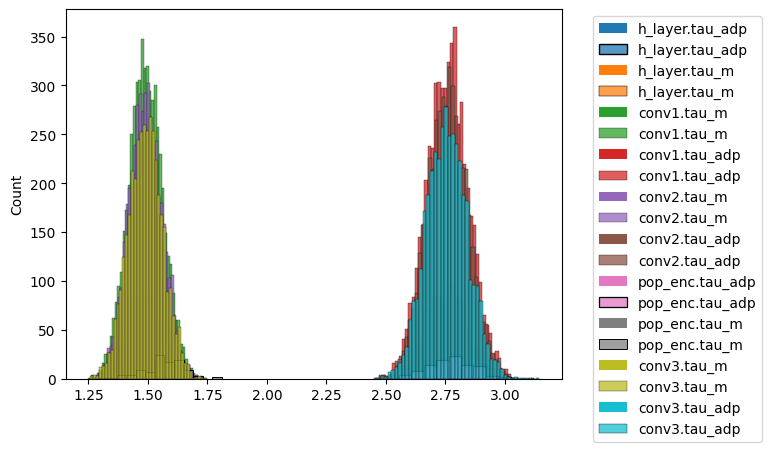

In [13]:
fig, ax = plt.subplots()

# plot your data
for name, param in param_dict.items():
    if 'tau_m' in name or 'tau_adp' in name:
        sns.histplot(param.flatten(), label=name, ax=ax)

# create legend outside plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

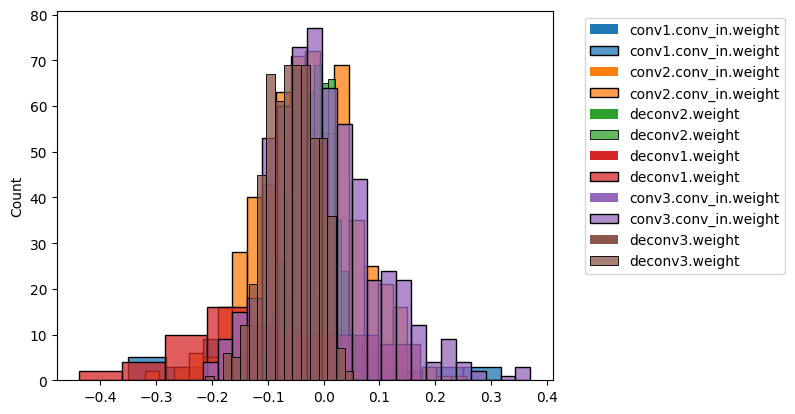

In [14]:
fig, ax = plt.subplots()

# plot your data
for name, param in param_dict.items():
    if ('conv_in' in name or 'deconv' in name) and 'weight' in name:
        sns.histplot(param.flatten(), label=name, ax=ax)

# create legend outside plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

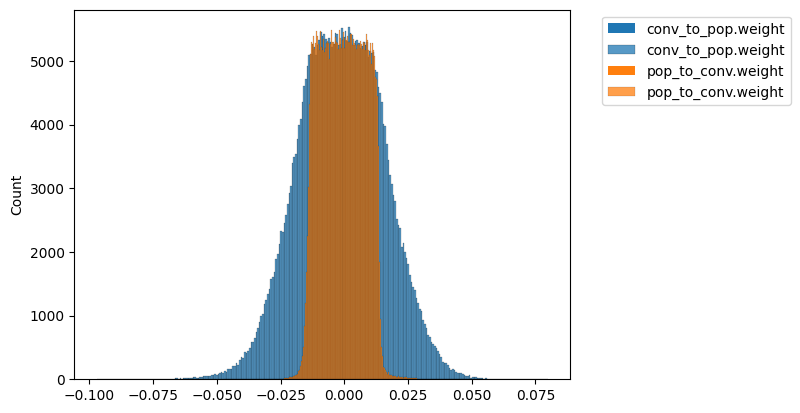

In [15]:
fig, ax = plt.subplots()

# plot your data
for name, param in param_dict.items():
    if ('pop' in name and 'conv' in name) and 'weight' in name:
        sns.histplot(param.flatten(), label=name, ax=ax)

# create legend outside plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

<AxesSubplot: ylabel='Count'>

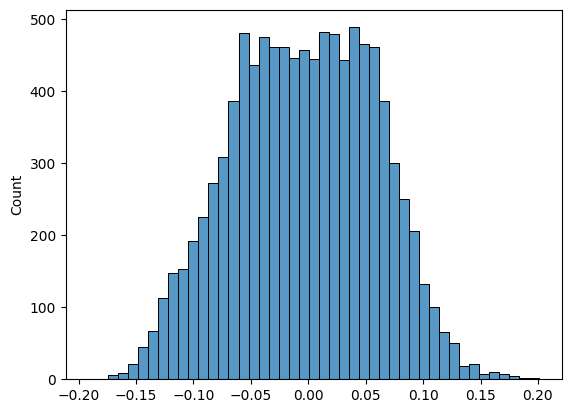

In [16]:
sns.histplot(param_dict['pop_enc.rec_w.weight'].flatten())

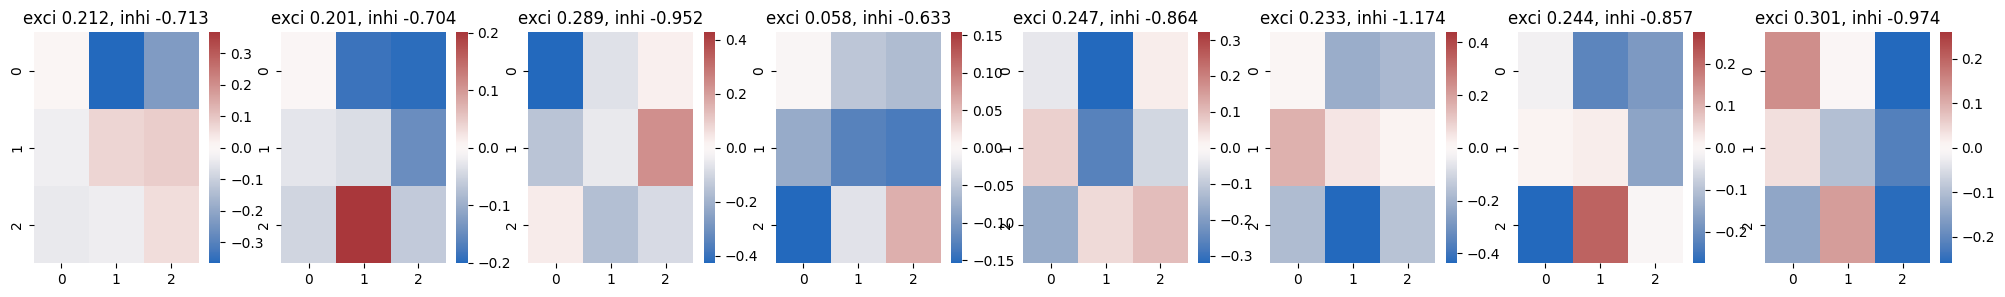

In [22]:
k = model.conv1.conv_in.weight.detach().cpu().numpy()

fig, axs = plt.subplots(1, len(k), figsize=(25, 3))
plt.title('conv 1 kernels')
for i in range(len(k)):
    abs_max = np.max(np.abs(k[i]))
    sns.heatmap(k[i].squeeze(), ax=axs[i], vmax=abs_max, vmin=-abs_max, cmap='vlag')
    axs[i].set_title('exci %.3f, inhi %.3f' % (((k[i]>0)*k[i]).sum(), ((k[i]<0)*k[i]).sum()))
plt.show()

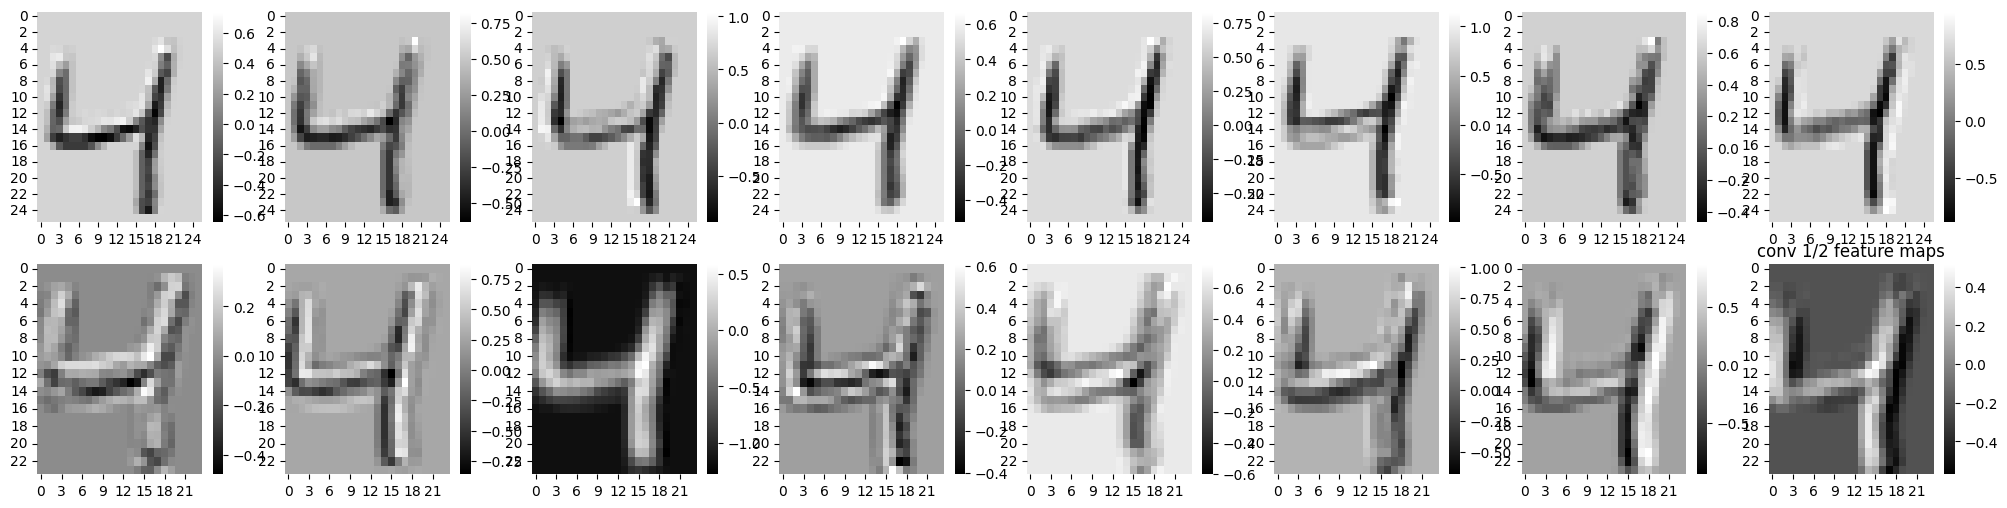

In [23]:
img = sample_data[2]
conv1 = model.conv1.conv_in.weight.detach().cpu()
conv1_bias = model.conv1.conv_in.bias.detach().cpu()

conv2 = model.conv2.conv_in.weight.detach().cpu()
conv2_bias = model.conv2.conv_in.bias.detach().cpu()

feature1 = F.conv2d(img, conv1, bias=conv1_bias, stride=1, padding=0)
feature2 = F.conv2d(feature1, conv2, bias=conv2_bias, stride=1, padding=0)


fig, axs = plt.subplots(2, len(conv1), figsize=(25, 6))
plt.title('conv 1/2 feature maps')
for i in range(len(conv1)):
    sns.heatmap(feature1[i].squeeze(), ax=axs[0][i], cmap='gray')
    sns.heatmap(feature2[i].squeeze(), ax=axs[1][i], cmap='gray')
plt.show()

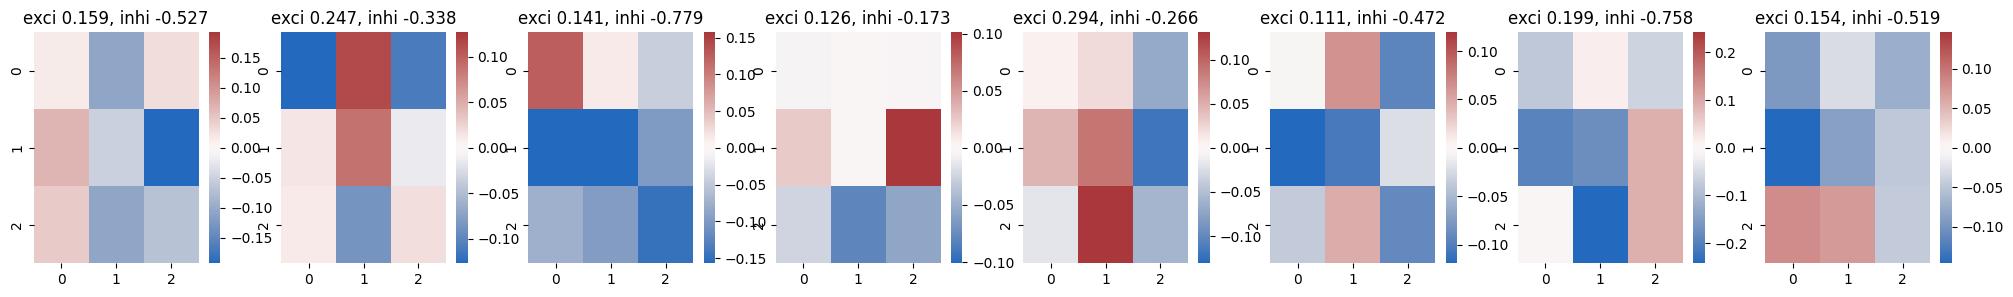

In [24]:
# deconv
deconv1 = model.deconv1.weight.detach().cpu().numpy()

fig, axs = plt.subplots(1, len(deconv1), figsize=(25, 3))
plt.title('deconv 1 kernels')
for i in range(len(deconv1)):
    abs_max = np.max(np.abs(deconv1[i]))
    sns.heatmap(deconv1[i].squeeze(), ax=axs[i], vmax=abs_max, vmin=-abs_max, cmap='vlag')
    axs[i].set_title('exci %.3f, inhi %.3f' % (((deconv1[i]>0)*deconv1[i]).sum(), ((deconv1[i]<0)*deconv1[i]).sum()))
plt.show()

(8, 8, 3, 3)


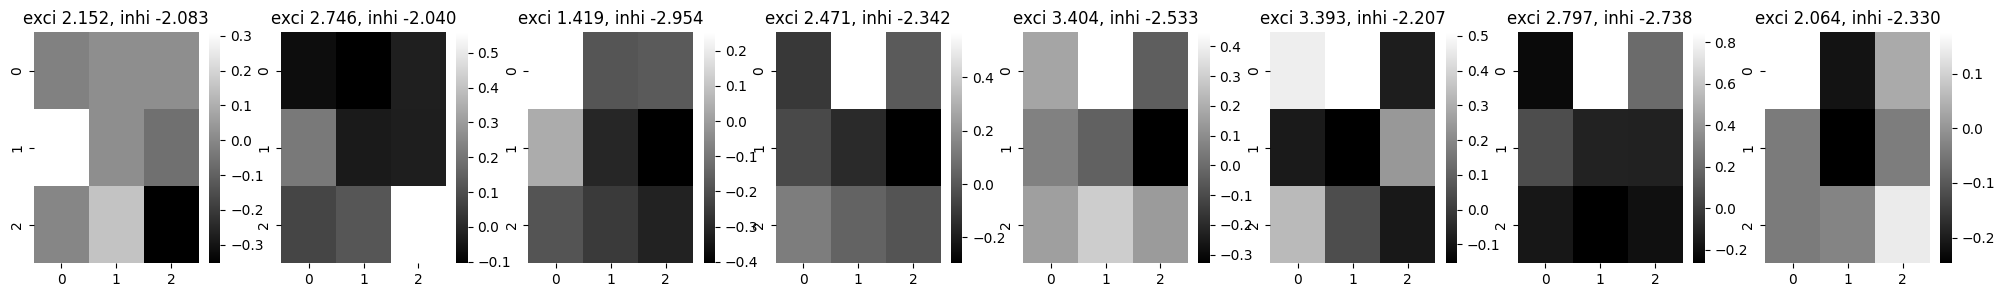

In [25]:
k2 = model.conv2.conv_in.weight.detach().cpu().numpy()

print(k2.shape)

fig, axs = plt.subplots(1, len(k), figsize=(25, 3))
plt.title('conv 1 kernels')
for i in range(len(k2)):
    sns.heatmap(k2[i].sum(axis=0), ax=axs[i], cmap='gray')
    axs[i].set_title('exci %.3f, inhi %.3f' % (((k2[i]>0)*k2[i]).sum(), ((k2[i]<0)*k2[i]).sum()))
plt.show()

(8, 8, 3, 3)


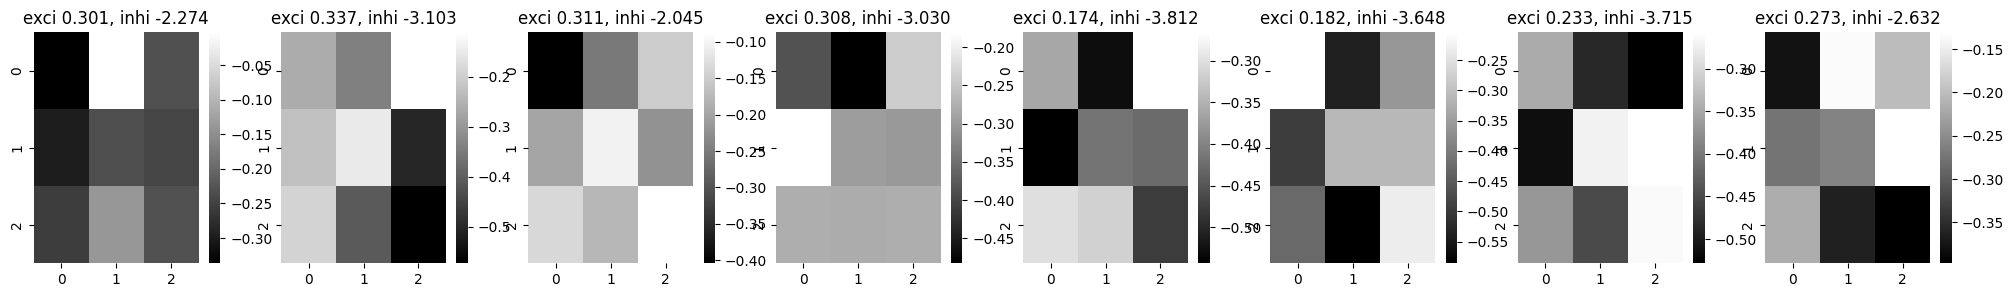

In [26]:
deconv2 = model.deconv2.weight.detach().cpu().numpy()

print(deconv2.shape)

fig, axs = plt.subplots(1, len(deconv2), figsize=(25, 3))
plt.title('conv 1 kernels')
for i in range(len(deconv2)):
    sns.heatmap(deconv2[i].sum(axis=0), ax=axs[i], cmap='gray')
    axs[i].set_title('exci %.3f, inhi %.3f' % (((deconv2[i]>0)*deconv2[i]).sum(), ((deconv2[i]<0)*deconv2[i]).sum()))
plt.show()

<AxesSubplot: >

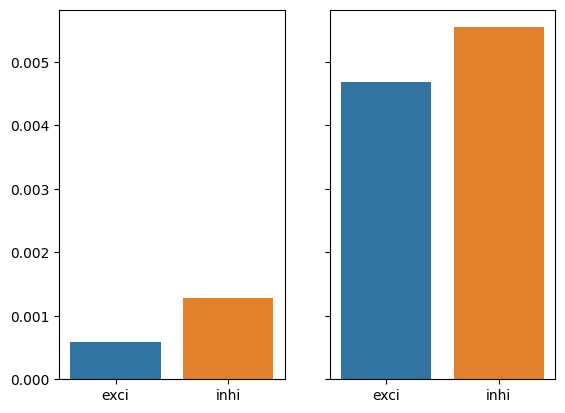

In [27]:
pop_to_conv = model.pop_to_conv.weight.detach().cpu()
conv_to_pop = model.conv_to_pop.weight.detach().cpu()

fig, axs = plt.subplots(1, 2, sharey=True)
sns.barplot(x=['exci', 'inhi'], y=[(pop_to_conv*(pop_to_conv>0)).numpy().mean(), -(pop_to_conv*(pop_to_conv<0)).numpy().mean()], ax=axs[0])
sns.barplot(x=['exci', 'inhi'], y=[(conv_to_pop*(conv_to_pop>0)).numpy().mean(), -(conv_to_pop*(conv_to_pop<0)).numpy().mean()], ax=axs[1])


In [28]:
pop_to_conv = model.pop_to_conv.weight.detach().cpu()
deconv1 = model.deconv1.weight.detach().cpu()
deconv1_bias = model.deconv1.bias.detach().cpu()
deconv2 = model.deconv2.weight.detach().cpu()
deconv2_bias = model.deconv2.bias.detach().cpu()
# deconv3 = model.deconv3.weight.detach().cpu()
# deconv3_bias = model.deconv3.bias.detach().cpu()
# deconv4 = model.deconv4.weight.detach().cpu()
# deconv4_bias = model.deconv4.bias.detach().cpu()

# per pop encoding neuron detection of input in input space 

def visualise(index):
    conv2_f = pop_to_conv[:, index*10:(index+1)*10].sum(dim=1).reshape(model.conv2.output_shape)
    conv1_f = torch.nn.functional.conv_transpose2d(conv2_f, deconv2, bias=deconv2_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)
    input = torch.nn.functional.conv_transpose2d(conv1_f, deconv1, bias=deconv1_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)

    return input

# def visualise(index):
#     conv4_f = ((pop_to_conv[:, index*10:(index+1)*10]>00)*pop_to_conv[:, index*10:(index+1)*10]).sum(dim=1).reshape(model.conv4.output_shape)
#     conv3_f = torch.nn.functional.conv_transpose2d(conv4_f, deconv4, bias=deconv4_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)
#     conv2_f = torch.nn.functional.conv_transpose2d(conv3_f, deconv3, bias=deconv3_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)
#     conv1_f = torch.nn.functional.conv_transpose2d(conv2_f, deconv2, bias=deconv2_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)
#     input = torch.nn.functional.conv_transpose2d(conv1_f, deconv1, bias=deconv1_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)

#     return input

# def visualise(index):
#     conv1_f = pop_to_conv[:, index*10:(index+1)*10].sum(dim=1).reshape(model.conv1.output_shape)
#     input = torch.nn.functional.conv_transpose2d(conv1_f, deconv1, bias=deconv1_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)

#     return input


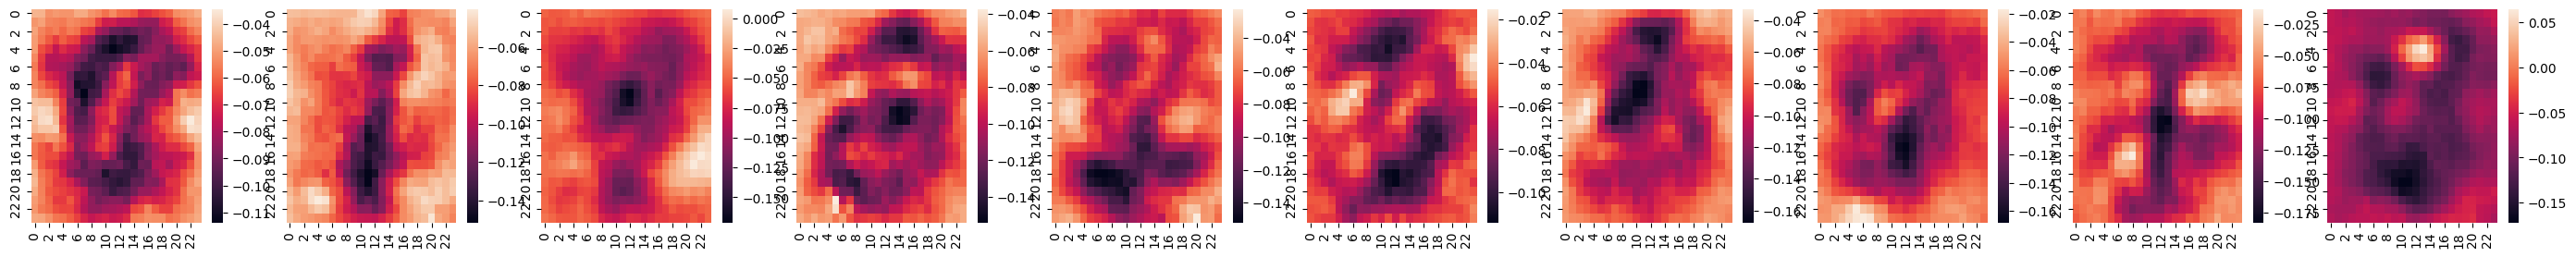

In [30]:
fig, axs = plt.subplots(1, 10, figsize=(35, 3))

for i in range(10):
    im = visualise(i)
    sns.heatmap(im.squeeze()[2:-2, 2:-2], ax=axs[i])

In [13]:
# get one batch of data
images = 0
preds = 0
hiddens = 0

# for data, target in test_loader:
for i, (data, target) in enumerate(test_loader):
    images = data.data
    data, target = data.to(device), target.to(device)

    with torch.no_grad():
        model.eval()
        hidden = model.init_hidden(data.size(0))

        log_softmax_outputs, hidden = model.inference(data, hidden, T)

        pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]

preds = preds.flatten().cpu().numpy()



AttributeError: 'int' object has no attribute 'flatten'

OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB (GPU 0; 11.93 GiB total capacity; 9.75 GiB already allocated; 57.44 MiB free; 10.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF